In [1]:
from pathlib import Path
import os
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
import statkit
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.express as px
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
from sklearn.model_selection import KFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.calibration import calibration_curve
import seaborn as sns
from typing import List, Tuple
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


sns.set_theme()

## Predicting Numerical Values with Machine Learning

- MLR
- Lasso regression
- KNN
- Random Forest
- XGBoost

In [2]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ---------------------------
# 1. Load Data
# ---------------------------
# Load your field mapping that contains "Field Name", "Source", and "Indicator Category"
fieldMapping_df = pd.read_csv('Field Mapping List.csv')
print("Field Mapping Preview:")
print(fieldMapping_df.head())

# Load your cleaned dataset
df = pd.read_csv('Group1DatasetCleaned.csv')

# ---------------------------
# 2. Drop Unwanted Columns
# ---------------------------
# Define initial drop list for essential columns you do not want in predictors
dropList = ['Life expectancy at birth, total (years)', 'CountryShortName', 'Year']

# Identify columns that contain "male" or "female" (ignore case)
cols_to_drop = [col for col in df.columns if 'male' in col.lower() or 'female' in col.lower()]

# Combine the initial dropList with the columns identified above
all_drop_columns = list(set(dropList + cols_to_drop))

# Create the target variable (Y) and a predictor DataFrame (df_predictors) containing all non-dropped columns
Y = df['Life expectancy at birth, total (years)']
df_predictors = df.drop(columns=all_drop_columns)

# ---------------------------
# 3. Create Indicator Category Sets
# ---------------------------
# Get lists of column names from the field mapping for each indicator category.
# (These lists come from the "Field Mapping List.csv" where each row has a "Field Name" and an "Indicator Category".)

env_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Environmental', 'Field Name'])
socio_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Socioeconomic', 'Field Name'])
health_cols = set(fieldMapping_df.loc[fieldMapping_df['Indicator Category'] == 'Health', 'Field Name'])

# Ensure that we only retain those columns which exist in the predictors DataFrame.
env_cols = list(env_cols.intersection(set(df_predictors.columns)))
socio_cols = list(socio_cols.intersection(set(df_predictors.columns)))
health_cols = list(health_cols.intersection(set(df_predictors.columns)))

# Create separate predictor sets for each category
X_env = df_predictors[env_cols]
X_socio = df_predictors[socio_cols]
X_health = df_predictors[health_cols]

print("Environmental columns:")
print(env_cols)
print("\nSocioeconomic columns:")
print(socio_cols)
print("\nHealth columns:")
print(health_cols)

# ---------------------------
# 4. Define VIF Functions
# ---------------------------
def calculate_vif(df_subset):
    """Calculate VIF for each numerical feature in a DataFrame."""
    vif_data = pd.DataFrame()
    vif_data["feature"] = df_subset.columns
    vif_data["VIF"] = [
        round(variance_inflation_factor(df_subset.values, i), 4) for i in range(df_subset.shape[1])
    ]
    return vif_data

def iterative_vif_drop(X, threshold=4):
    """
    Iteratively drop the column with the highest VIF above `threshold` until
    all remaining columns have VIF <= threshold.
    """
    while True:
        vif_df = calculate_vif(X)
        max_vif = vif_df["VIF"].max()
        if max_vif > threshold:
            drop_col = vif_df.loc[vif_df["VIF"].idxmax(), "feature"]
            print(f"Dropping '{drop_col}' with VIF={max_vif:.2f}")
            X = X.drop(columns=[drop_col])
        else:
            break
    return X

# ---------------------------
# 5. Evaluate Each Predictor Set Using VIF
# ---------------------------
print("\n--- Environmental Predictors VIF ---")
vif_env = calculate_vif(X_env)
print(vif_env)
X_env_reduced = iterative_vif_drop(X_env, threshold=4)
print("Final VIF for Environmental predictors:")
print(calculate_vif(X_env_reduced))

print("\n--- Socioeconomic Predictors VIF ---")
vif_socio = calculate_vif(X_socio)
print(vif_socio)
X_socio_reduced = iterative_vif_drop(X_socio, threshold=4)
print("Final VIF for Socioeconomic predictors:")
print(calculate_vif(X_socio_reduced))

print("\n--- Health Predictors VIF ---")
vif_health = calculate_vif(X_health)
print(vif_health)
X_health_reduced = iterative_vif_drop(X_health, threshold=4)
print("Final VIF for Health predictors:")
print(calculate_vif(X_health_reduced))


Field Mapping Preview:
                                          Field Name                   Source  \
0    GOAL 13: Climate Action (5 year moving average)             SPIIndicator   
1  Fluorinated greenhouse gases (F-gases) emissio...  WDIEnvironmentIndicator   
2  Total greenhouse gas emissions including LULUC...  WDIEnvironmentIndicator   
3  Carbon dioxide (CO2) net fluxes from LULUCF - ...  WDIEnvironmentIndicator   
4  Carbon dioxide (CO2) net fluxes from LULUCF - ...  WDIEnvironmentIndicator   

  Indicator Category  
0      Environmental  
1      Environmental  
2      Environmental  
3      Environmental  
4      Environmental  
Environmental columns:
['Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)', 'Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)', 'Total greenhouse gas emissions including LULUCF (Mt CO2e)', 'Access to clean fuels and technologies for cooking, rural (% of rural population)', 'Forest area (% of land area)', 'Fluorinated 

In [3]:
vif_dropList = [
    "Rural population (% of total population)","Region_South Asia","GDP, PPP (current international $)","Prevalence of anemia among women of reproductive age (% of women ages 15-49)","Total greenhouse gas emissions excluding LULUCF (Mt CO2e)","GNI (current US$)","Carbon dioxide (CO2) emissions (total) excluding LULUCF (Mt CO2e)","Domestic credit to private sector by banks (% of GDP)","Nitrous oxide (N2O) emissions (total) excluding LULUCF (Mt CO2e)","GDP (current US$)","Number of infant deaths","Wage and salaried workers, total (% of total employment) (modeled ILO estimate)","Labor force, total","Methane (CH4) emissions (total) excluding LULUCF (Mt CO2e)","Employment to population ratio, 15+, total (%) (modeled ILO estimate)","Nitrous oxide (N2O) emissions from Industrial Combustion (Energy) (Mt CO2e)","Population ages 0-14, total","Current health expenditure per capita (current US$)","GDP (constant 2015 US$)","Total fisheries production (metric tons)","GNI, Atlas method (current US$)","Surface area (sq. km)","Access to clean fuels and technologies for cooking (% of population)","GDP, PPP (constant 2021 international $)","GDP per capita, PPP (current international $)","Carbon dioxide (CO2) emissions from Transport (Energy) (Mt CO2e)","Number of deaths ages 10-14 years","Number of under-five deaths","Current health expenditure per capita, PPP (current international $)","GDP per capita (current US$)","Employment to population ratio, ages 15-24, total (%) (modeled ILO estimate)","Domestic private health expenditure per capita, PPP (current international $)","Mortality rate, under-5 (per 1,000 live births)","GDP per capita, PPP (constant 2021 international $)","Urban population","Final consumption expenditure (constant 2015 US$)","Vulnerable employment, total (% of total employment) (modeled ILO estimate)","Carbon dioxide (CO2) emissions from Industrial Combustion (Energy) (Mt CO2e)","GNI per capita, Atlas method (current US$)","Nitrous oxide (N2O) emissions from Agriculture (Mt CO2e)","Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)","Carbon dioxide (CO2) emissions from Power Industry (Energy) (Mt CO2e)","Number of deaths ages 15-19 years","Domestic general government health expenditure per capita (current US$)","Nitrous oxide (N2O) emissions from Waste (Mt CO2e)","Income Group_High income","Lifetime risk of maternal death (%)","Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)","Adjusted net national income (current US$)","Population ages 0-14 (% of total population)","Rural population","People using at least basic sanitation services (% of population)","Total greenhouse gas emissions including LULUCF (Mt CO2e)","GDP growth (annual %)","GNI, PPP (current international $)","Nitrous oxide (N2O) emissions from Transport (Energy) (Mt CO2e)","Mortality rate, infant (per 1,000 live births)","GDP per capita (constant 2015 US$)","Land under cereal production (hectares)","Out-of-pocket expenditure per capita (current US$)","Computer, communications and other services (% of commercial service imports)","Forest area (sq. km)","Number of deaths ages 20-24 years","Carbon dioxide (CO2) emissions from Industrial Processes (Mt CO2e)","Domestic general government health expenditure (% of GDP)","Nitrous oxide (N2O) emissions from Building (Energy) (Mt CO2e)","Prevalence of anemia among pregnant women (%)","Number of deaths ages 5-9 years","Computer, communications and other services (% of commercial service exports)","Methane (CH4) emissions from Agriculture (Mt CO2e)","GNI per capita, PPP (current international $)","Access to electricity (% of population)","Oil rents (% of GDP)","Birth rate, crude (per 1,000 people)","Cereal production (metric tons)","Carbon dioxide (CO2) emissions from Fugitive Emissions (Energy) (Mt CO2e)","Probability of dying among children ages 5-9 years (per 1,000)","Domestic private health expenditure (% of current health expenditure)","Exports of goods, services and primary income (BoP, current US$)","Region_Europe & Central Asia","Adjusted net national income per capita (current US$)","Probability of dying among adolescents ages 15-19 years (per 1,000)","Monetary Sector credit to private sector (% GDP)","Carbon dioxide (CO2) emissions from Building (Energy) (Mt CO2e)","Prevalence of anemia among children (% of children ages 6-59 months)","Methane (CH4) emissions from Waste (Mt CO2e)","Unemployment, total (% of total labor force) (modeled ILO estimate)","Primary education, pupils","School enrollment, primary (% gross)","Crop production index (2014-2016 = 100)","Livestock production index (2014-2016 = 100)","Carbon intensity of GDP (kg CO2e per 2021 PPP $)","Access to clean fuels and technologies for cooking, urban (% of urban population)","People using at least basic sanitation services, rural (% of rural population)","GOAL 17: Partnerships to achieve the Goal (5 year moving average)","Land area (sq. km)","Share of youth not in education, employment or training, total (% of youth population) (modeled ILO estimate)","Fluorinated greenhouse gases (F-gases) emissions from Industrial Processes (Mt CO2e)","People using at least basic drinking water services (% of population)","Travel services (% of commercial service exports)","GDP per person employed (constant 2021 PPP $)","Number of neonatal deaths","General government final consumption expenditure (constant 2015 US$)","People using at least basic drinking water services, urban (% of urban population)","Population ages 15-64 (% of total population)","Immunization, DPT (% of children ages 12-23 months)","Pillar 3 - Data Products - Score","Labor force participation rate, total (% of total population ages 15+) (modeled ILO estimate)","Access to electricity, urban (% of urban population)","People using at least basic sanitation services, urban (% of urban population)","Import unit value index (2015 = 100)","Immunization, measles (% of children ages 12-23 months)","GOAL 15: Life on Land (5 year moving average)","Women Business and the Law Index Score (scale 1-100)","Domestic general government health expenditure (% of current health expenditure)","Tuberculosis case detection rate (%, all forms)","Food production index (2014-2016 = 100)","Tuberculosis treatment success rate (% of new cases)","Communications, computer, etc. (% of service imports, BoP)","Urban population (% of total population)","Death rate, crude (per 1,000 people)","Export unit value index (2015 = 100)","Self-employed, total (% of total employment) (modeled ILO estimate)","Access to electricity, rural (% of rural population)","Compulsory education, duration (years)","Mortality rate, neonatal (per 1,000 live births)","Labor force participation rate for ages 15-24, total (%) (modeled ILO estimate)","Current health expenditure (% of GDP)","Renewable energy consumption (% of total final energy consumption)","Prevalence of anemia among non-pregnant women (% of women ages 15-49)","GOAL 1: No Poverty (5 year moving average)","GOAL 10: Reduced Inequality (5 year moving average)","Probability of dying among youth ages 20-24 years (per 1,000)","Household Survey on income, etc (Availability score over 10 years)","Inflation, GDP deflator: linked series (annual %)","Adolescent fertility rate (births per 1,000 women ages 15-19)","Out-of-pocket expenditure per capita, PPP (current international $)","Carbon intensity of GDP (kg CO2e per constant 2021 US$ of GDP)","Access to clean fuels and technologies for cooking, rural (% of rural population)","Agricultural land (% of land area)","Nitrous oxide (N2O) emissions from Industrial Processes (Mt CO2e)","GOAL 16: Peace and Justice Strong Institutions (5 year moving average)","Carbon dioxide (CO2) net fluxes from LULUCF - Deforestation (Mt CO2e)","Domestic general government health expenditure per capita, PPP (current international $)","Transport services (% of commercial service imports)","Total natural resources rents (% of GDP)","Broad money (% of GDP)","Adjusted savings: education expenditure (% of GNI)","Pillar 1 - Data Use - Score","Energy intensity level of primary energy (MJ/$2017 PPP GDP)","Methane (CH4) emissions from Industrial Combustion (Energy) (Mt CO2e)","Agriculture, forestry, and fishing, value added (% of GDP)","Probability of dying among adolescents ages 10-14 years (per 1,000)","Methane (CH4) emissions from Power Industry (Energy) (Mt CO2e)","PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)","Prevalence of stunting, height for age (modeled estimate, % of children under 5)","GOAL 11: Sustainable Cities and Communities (5 year moving average)","Income Group_Lower middle income","International tourism, receipts for travel items (current US$)","Preprimary education, duration (years)","Total greenhouse gas emissions excluding LULUCF (% change from 1990)","Methane (CH4) emissions from Building (Energy) (Mt CO2e)","Exports of goods and services (% of GDP)","Domestic credit to private sector (% of GDP)","Methane (CH4) emissions from Transport (Energy) (Mt CO2e)","Maternal mortality ratio (modeled estimate, per 100,000 live births)","Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)","Methane (CH4) emissions from Fugitive Emissions (Energy) (Mt CO2e)","Health/Demographic survey (Availability score over 10 years)","Prevalence of overweight (modeled estimate, % of children under 5)","Out-of-pocket expenditure (% of current health expenditure)","Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)","Urban population growth (annual %)","Forest area (% of land area)","Renewable internal freshwater resources, total (billion cubic meters)","Automated teller machines (ATMs) (per 100,000 adults)","Adjusted savings: carbon dioxide damage (% of GNI)","Proportion of seats held by women in national parliaments (%)","Domestic private health expenditure per capita (current US$)","GOAL 12: Responsible Consumption and Production (5 year moving average)","Nitrous oxide (N2O) emissions from Power Industry (Energy) (Mt CO2e)","Labor Force Survey (Availability score over 10 years)","Fuel imports (% of merchandise imports)","Fuel exports (% of merchandise exports)","Prevalence of undernourishment (% of population)","Arable land (% of land area)","Insurance and financial services (% of commercial service imports)","Region_Sub-Saharan Africa","Communications, computer, etc. (% of service exports, BoP)","Travel services (% of commercial service imports)","Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)" 
]

# X_reduced = X.drop(vif_dropList, axis=1)

In [4]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# --- Assume that these helper functions have been defined previously ---

def scale_split_data(X, Y, test_size=0.2, random_state=135):
    """
    Convert data to float, perform train-test split,
    scale the data using StandardScaler, and add a constant for the intercept.
    """
    X = X.astype(float)
    Y = Y.astype(float)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Initialize and fit the StandardScaler on training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert scaled arrays back to DataFrames to preserve column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Add a constant to account for the intercept in the regression model
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

def fit_ols_and_evaluate(X_train_scaled, y_train, X_test_scaled, y_test):
    """
    Fit an OLS regression model using statsmodels, print the model summary,
    perform predictions on the test set, and calculate performance metrics.
    """
    model = sm.OLS(y_train, X_train_scaled).fit()
    print(model.summary())
    
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("Test Mean Squared Error:", mse)
    print("Test R-squared:", r2)
    
    results = {"y_pred": y_pred, "mse": mse, "r2": r2}
    return model, results

# fields dropped due to alpha being greater than 0.05
cols_to_remove = [
    "Permanent cropland (% of land area)",
    "Arable land (hectares per person)",
    "Carbon dioxide (CO2) net fluxes from LULUCF - Total excluding non-tropical fires (Mt CO2e)",
    "Carbon dioxide (CO2) net fluxes from LULUCF - Forest Land (Mt CO2e)",
    "Nitrous oxide (N2O) emissions from Fugitive Emissions (Energy) (Mt CO2e)",
    "Carbon dioxide (CO2) emissions (total) excluding LULUCF (% change from 1990)",
    "Methane (CH4) emissions (total) excluding LULUCF (% change from 1990)",
    "General government final consumption expenditure (annual % growth)",
    "Region_North America",
    "Official exchange rate (LCU per US$, period average)",
    "Refugee population by country or territory of origin",
    "Net migration",
    "GDP per capita growth (annual %)"
]

# --- Update and run the OLS model for each predictor category ---

# 1. Environmental Predictors
print("=== Environmental Predictors Model (After Removing Selected Columns) ===")
X_env_updated = X_env_reduced.drop(columns=cols_to_remove, errors='ignore')
X_train_env, X_test_env, y_train_env, y_test_env = scale_split_data(X_env_updated, Y)
model_env_updated, results_env_updated = fit_ols_and_evaluate(X_train_env, y_train_env, X_test_env, y_test_env)

# 2. Socioeconomic Predictors
print("\n=== Socioeconomic Predictors Model (After Removing Selected Columns) ===")
X_socio_updated = X_socio_reduced.drop(columns=cols_to_remove, errors='ignore')
X_train_socio, X_test_socio, y_train_socio, y_test_socio = scale_split_data(X_socio_updated, Y)
model_socio_updated, results_socio_updated = fit_ols_and_evaluate(X_train_socio, y_train_socio, X_test_socio, y_test_socio)

# 3. Health Predictors
print("\n=== Health Predictors Model (After Removing Selected Columns) ===")
X_health_updated = X_health_reduced.drop(columns=cols_to_remove, errors='ignore')
X_train_health, X_test_health, y_train_health, y_test_health = scale_split_data(X_health_updated, Y)
model_health_updated, results_health_updated = fit_ols_and_evaluate(X_train_health, y_train_health, X_test_health, y_test_health)


=== Environmental Predictors Model (After Removing Selected Columns) ===
                                       OLS Regression Results                                      
Dep. Variable:     Life expectancy at birth, total (years)   R-squared:                       0.665
Model:                                                 OLS   Adj. R-squared:                  0.662
Method:                                      Least Squares   F-statistic:                     252.4
Date:                                     Thu, 10 Apr 2025   Prob (F-statistic):               0.00
Time:                                             16:58:31   Log-Likelihood:                -6912.8
No. Observations:                                     2308   AIC:                         1.386e+04
Df Residuals:                                         2289   BIC:                         1.397e+04
Df Model:                                               18                                         
Covariance Type:           

In [ ]:
# saving used model fields
health_fields = pd.DataFrame(X_health_updated.columns.to_list())
env_fields = pd.DataFrame(X_env_updated.columns.to_list())
socio_fields = pd.DataFrame(X_socio_updated.columns.to_list())

health_fields.to_csv('health_fields.csv')
env_fields.to_csv('env_fields.csv')
socio_fields.to_csv('socio_fields.csv')

Category: Environmental
========== Environmental - Linear Regression ==========
Test MSE: 23.910611553637207
Test R²: 0.6639932265013571
Test MAE: 3.676561584111818
Test RMSE: 4.889847804751923
Test Median AE: 2.7829462100924687
Explained Variance: 0.6642811400366804
Adjusted R²: 0.6481380974433448
Cross-validated RMSE: 4.855383751717147
========== Environmental - Ridge Regression ==========
Test MSE: 23.908927123590374
Test R²: 0.6640168971592133
Test MAE: 3.676492261588193
Test RMSE: 4.889675564246607
Test Median AE: 2.784368408129019
Explained Variance: 0.6643037119309381
Adjusted R²: 0.6481628850469439
Cross-validated RMSE: 4.855327845694035
========== Environmental - Lasso Regression ==========
Test MSE: 23.85488735585326
Test R²: 0.6647762975600451
Test MAE: 3.6516888665591405
Test RMSE: 4.884146533003823
Test Median AE: 2.709931785071447
Explained Variance: 0.6649008598858993
Adjusted R²: 0.6489581192234954
Cross-validated RMSE: 4.879891894263337
========== Environmental - Elast

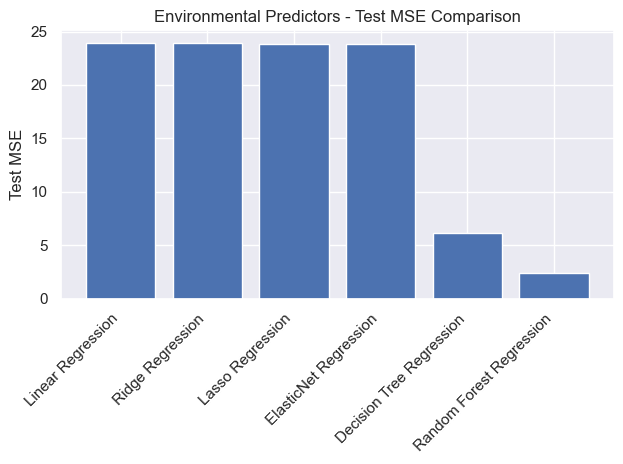


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression 23.910612
        Ridge Regression 23.908927
        Lasso Regression 23.854887
   ElasticNet Regression 23.828859
Decision Tree Regression  6.161206
Random Forest Regression  2.377523




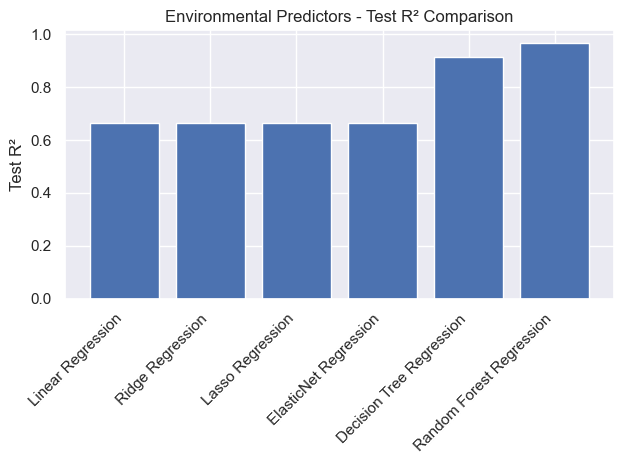


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.663993
        Ridge Regression 0.664017
        Lasso Regression 0.664776
   ElasticNet Regression 0.665142
Decision Tree Regression 0.913419
Random Forest Regression 0.966590




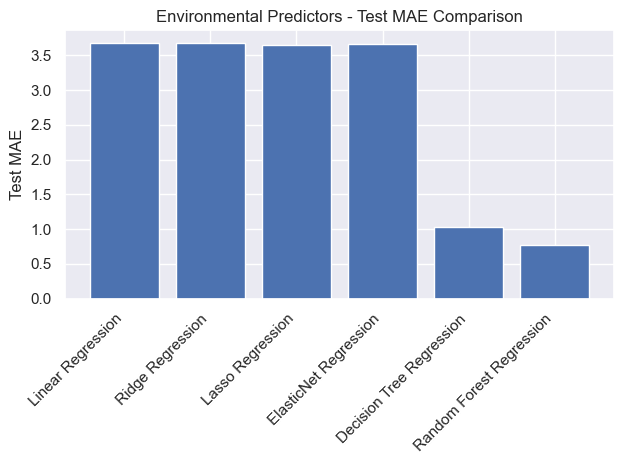


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  3.676562
        Ridge Regression  3.676492
        Lasso Regression  3.651689
   ElasticNet Regression  3.663989
Decision Tree Regression  1.031192
Random Forest Regression  0.765753




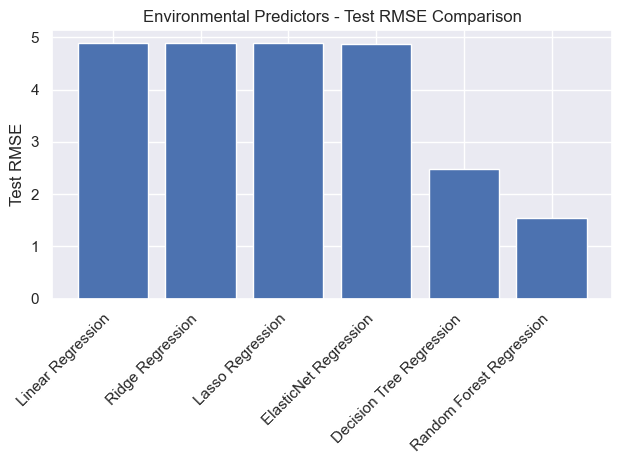


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   4.889848
        Ridge Regression   4.889676
        Lasso Regression   4.884147
   ElasticNet Regression   4.881481
Decision Tree Regression   2.482178
Random Forest Regression   1.541922




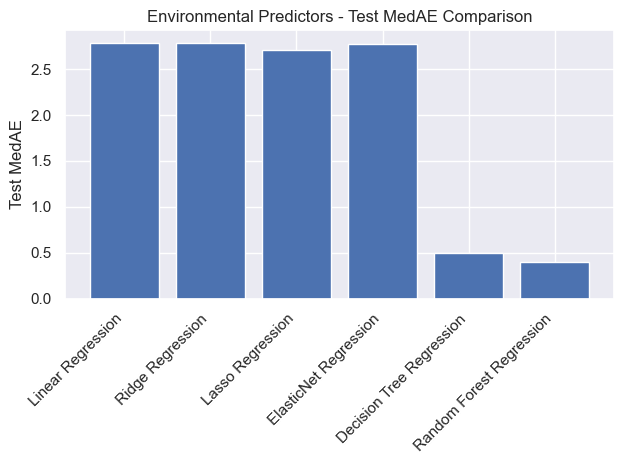


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    2.782946
        Ridge Regression    2.784368
        Lasso Regression    2.709932
   ElasticNet Regression    2.773246
Decision Tree Regression    0.500220
Random Forest Regression    0.397136




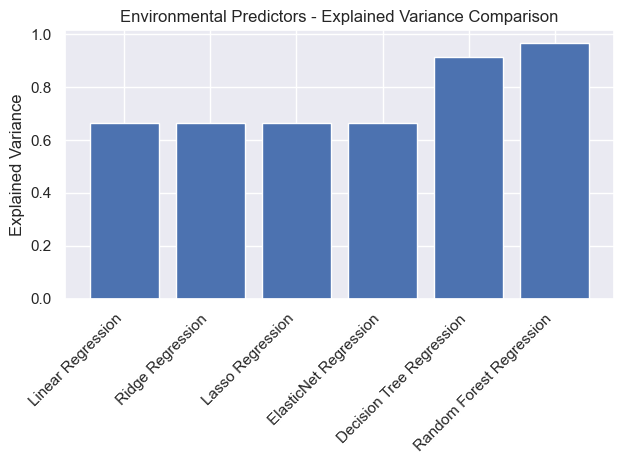


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.664281
        Ridge Regression            0.664304
        Lasso Regression            0.664901
   ElasticNet Regression            0.665267
Decision Tree Regression            0.913559
Random Forest Regression            0.966841




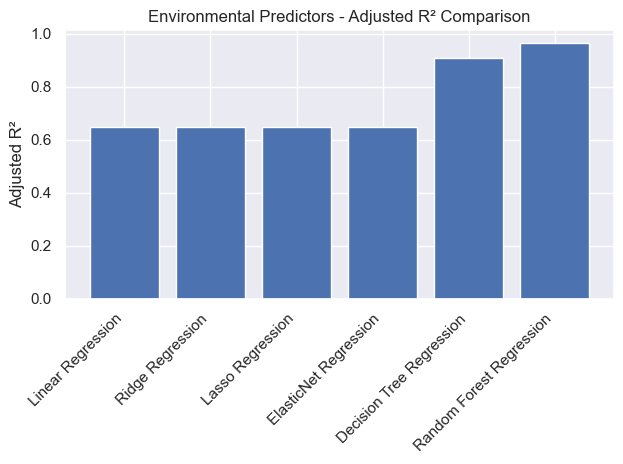


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.648138
        Ridge Regression     0.648163
        Lasso Regression     0.648958
   ElasticNet Regression     0.649341
Decision Tree Regression     0.909333
Random Forest Regression     0.965013




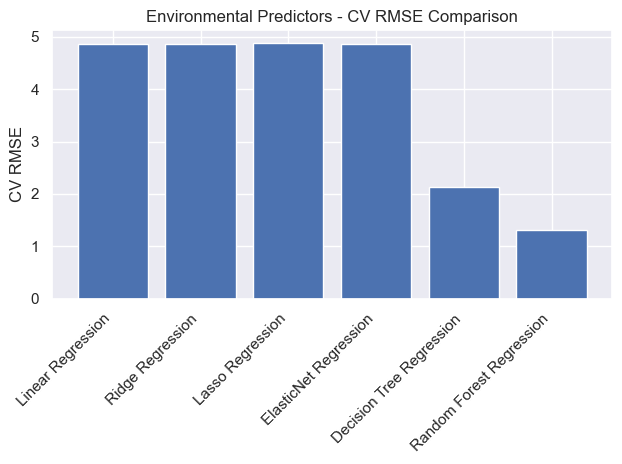


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 4.855384
        Ridge Regression 4.855328
        Lasso Regression 4.879892
   ElasticNet Regression 4.871512
Decision Tree Regression 2.123370
Random Forest Regression 1.309890




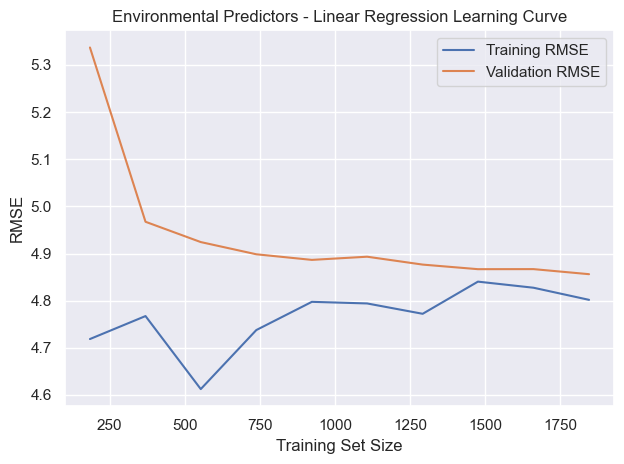

Category: Socioeconomic
========== Socioeconomic - Linear Regression ==========
Test MSE: 22.548560358423693
Test R²: 0.6831336163829385
Test MAE: 3.7635619559721585
Test RMSE: 4.748532442599892
Test Median AE: 3.1120979219852245
Explained Variance: 0.6832457102975753
Adjusted R²: 0.666365139877656
Cross-validated RMSE: 4.589667574903544
========== Socioeconomic - Ridge Regression ==========
Test MSE: 22.54845409418753
Test R²: 0.6831351096740261
Test MAE: 3.763388973246807
Test RMSE: 4.74852125342064
Test Median AE: 3.113568658332987
Explained Variance: 0.6832468667057984
Adjusted R²: 0.666366712193272
Cross-validated RMSE: 4.589599922242519
========== Socioeconomic - Lasso Regression ==========
Test MSE: 23.001830808797628
Test R²: 0.6767639783161423
Test MAE: 3.796051416370703
Test RMSE: 4.796022394526283
Test Median AE: 3.2373993172884
Explained Variance: 0.6768205130999522
Adjusted R²: 0.6596584224241133
Cross-validated RMSE: 4.621731083766126
========== Socioeconomic - ElasticNet

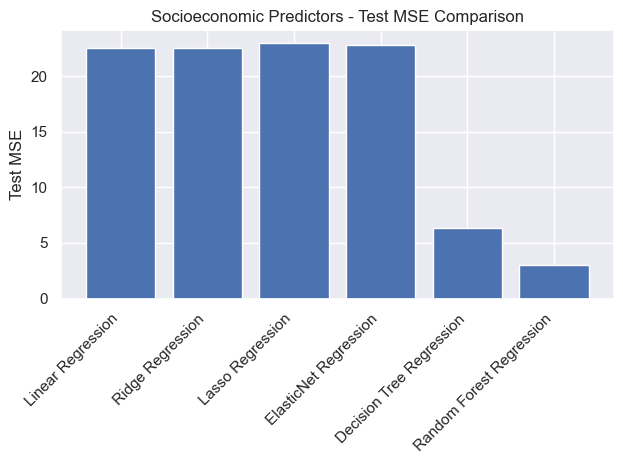


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression 22.548560
        Ridge Regression 22.548454
        Lasso Regression 23.001831
   ElasticNet Regression 22.852843
Decision Tree Regression  6.382839
Random Forest Regression  2.982949




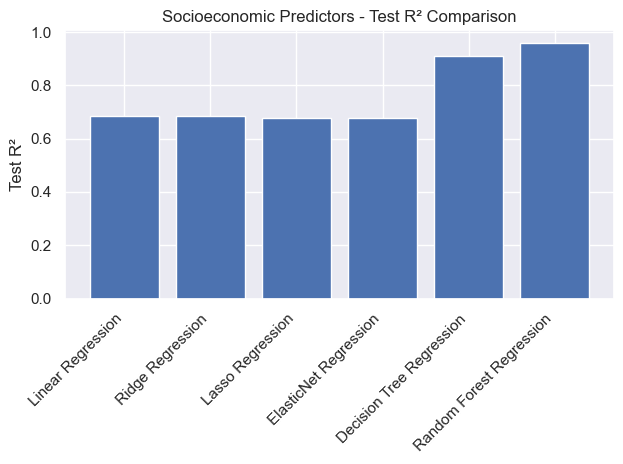


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.683134
        Ridge Regression 0.683135
        Lasso Regression 0.676764
   ElasticNet Regression 0.678858
Decision Tree Regression 0.910304
Random Forest Regression 0.958082




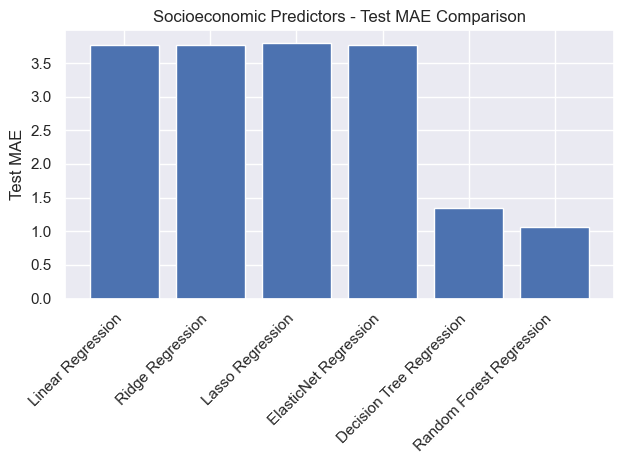


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  3.763562
        Ridge Regression  3.763389
        Lasso Regression  3.796051
   ElasticNet Regression  3.773600
Decision Tree Regression  1.339887
Random Forest Regression  1.062982




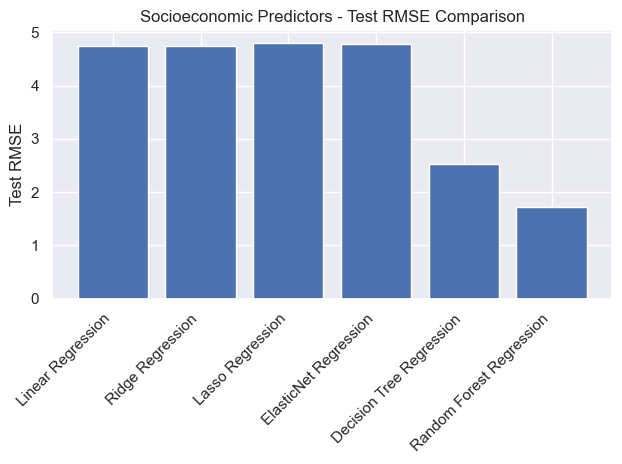


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   4.748532
        Ridge Regression   4.748521
        Lasso Regression   4.796022
   ElasticNet Regression   4.780465
Decision Tree Regression   2.526428
Random Forest Regression   1.727121




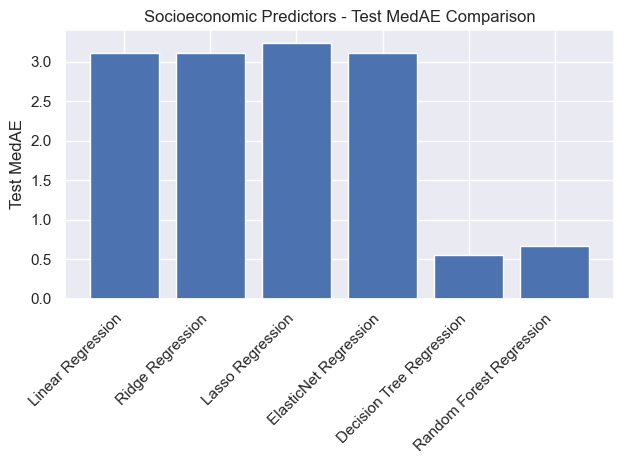


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    3.112098
        Ridge Regression    3.113569
        Lasso Regression    3.237399
   ElasticNet Regression    3.115286
Decision Tree Regression    0.555049
Random Forest Regression    0.664263




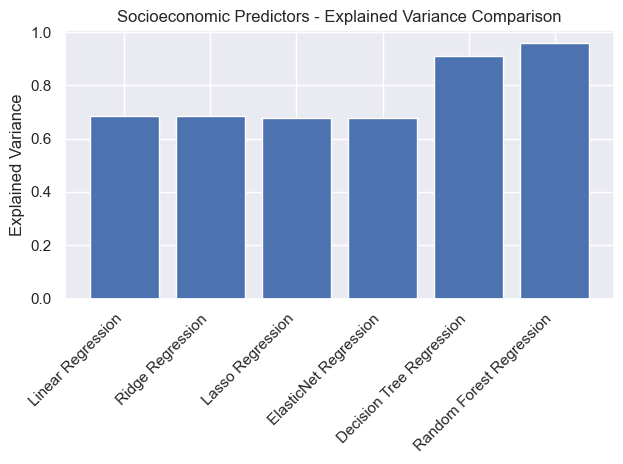


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.683246
        Ridge Regression            0.683247
        Lasso Regression            0.676821
   ElasticNet Regression            0.678910
Decision Tree Regression            0.910431
Random Forest Regression            0.958105




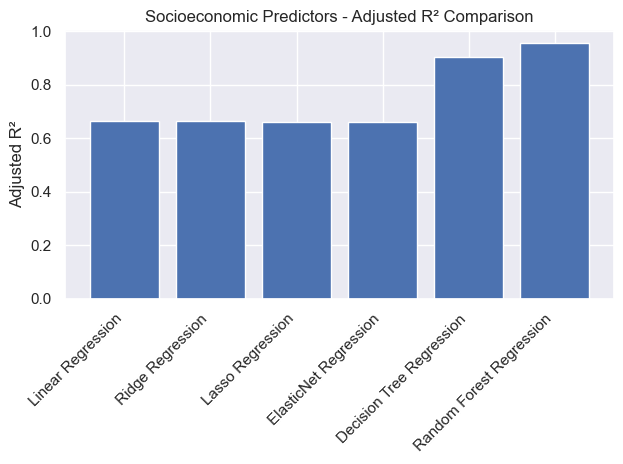


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.666365
        Ridge Regression     0.666367
        Lasso Regression     0.659658
   ElasticNet Regression     0.661863
Decision Tree Regression     0.905558
Random Forest Regression     0.955863




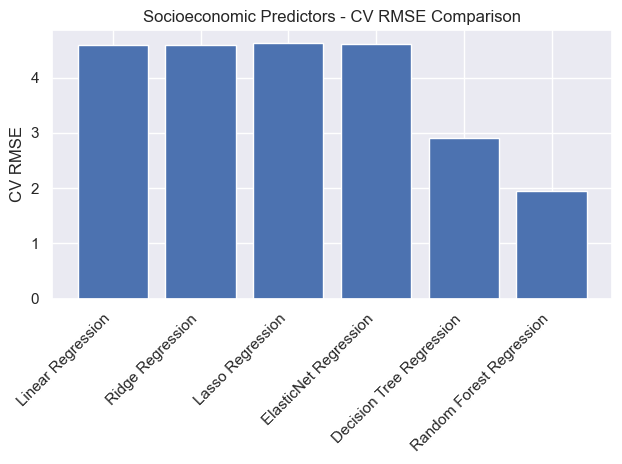


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 4.589668
        Ridge Regression 4.589600
        Lasso Regression 4.621731
   ElasticNet Regression 4.612201
Decision Tree Regression 2.905680
Random Forest Regression 1.953029




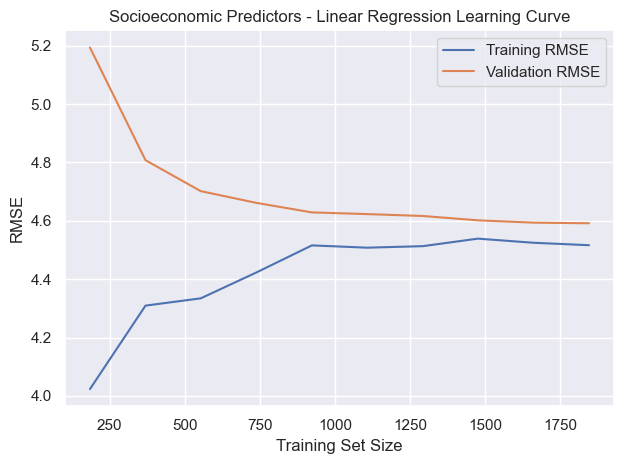

Category: Health
========== Health - Linear Regression ==========
Test MSE: 8.93177966391296
Test R²: 0.8744850812477164
Test MAE: 2.3308927479672876
Test RMSE: 2.9886083155731464
Test Median AE: 1.91694717877688
Explained Variance: 0.8749664228219095
Adjusted R²: 0.8720457453709052
Cross-validated RMSE: 2.909371550028573
========== Health - Ridge Regression ==========
Test MSE: 8.930734483447264
Test R²: 0.8744997687731783
Test MAE: 2.330788204801543
Test RMSE: 2.9884334497270078
Test Median AE: 1.9146501739392576
Explained Variance: 0.8749815297847008
Adjusted R²: 0.872060718342975
Cross-validated RMSE: 2.909333727392959
========== Health - Lasso Regression ==========
Test MSE: 8.919858280566924
Test R²: 0.8746526079353862
Test MAE: 2.3313697843166405
Test RMSE: 2.986613178931434
Test Median AE: 1.9410553335845684
Explained Variance: 0.875192336935925
Adjusted R²: 0.8722165278775934
Cross-validated RMSE: 2.9299066383574406
========== Health - ElasticNet Regression ==========
Test MSE

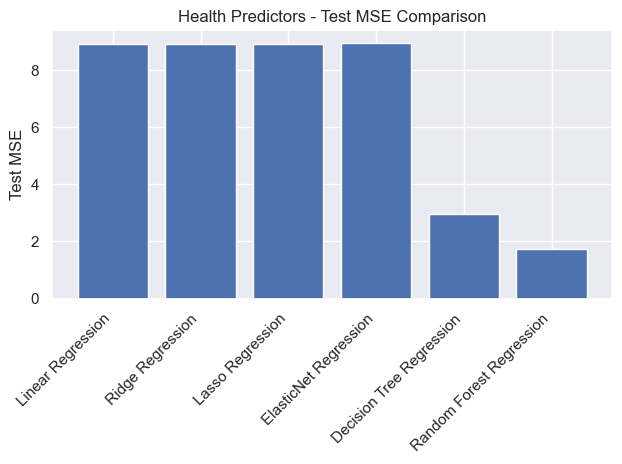


Summary Table for Test MSE:
                   Model  Test MSE
       Linear Regression  8.931780
        Ridge Regression  8.930734
        Lasso Regression  8.919858
   ElasticNet Regression  8.948168
Decision Tree Regression  2.951851
Random Forest Regression  1.729385




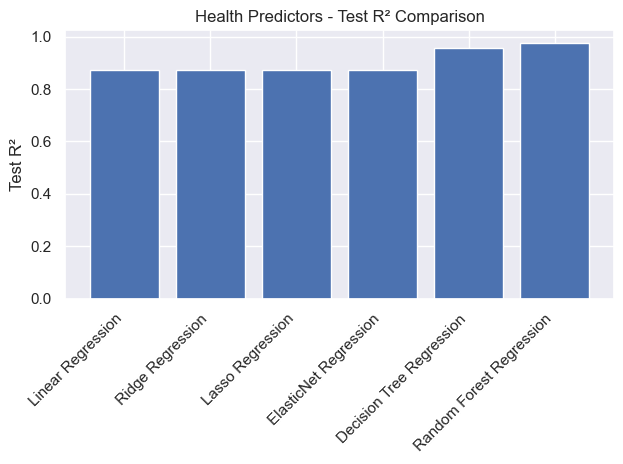


Summary Table for Test R²:
                   Model  Test R²
       Linear Regression 0.874485
        Ridge Regression 0.874500
        Lasso Regression 0.874653
   ElasticNet Regression 0.874255
Decision Tree Regression 0.958519
Random Forest Regression 0.975698




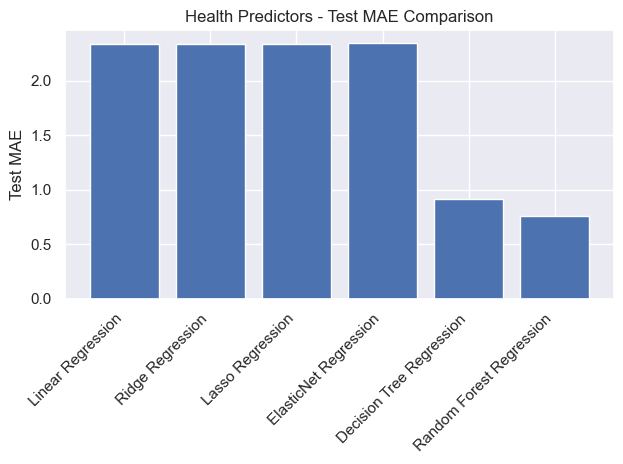


Summary Table for Test MAE:
                   Model  Test MAE
       Linear Regression  2.330893
        Ridge Regression  2.330788
        Lasso Regression  2.331370
   ElasticNet Regression  2.342440
Decision Tree Regression  0.912241
Random Forest Regression  0.752560




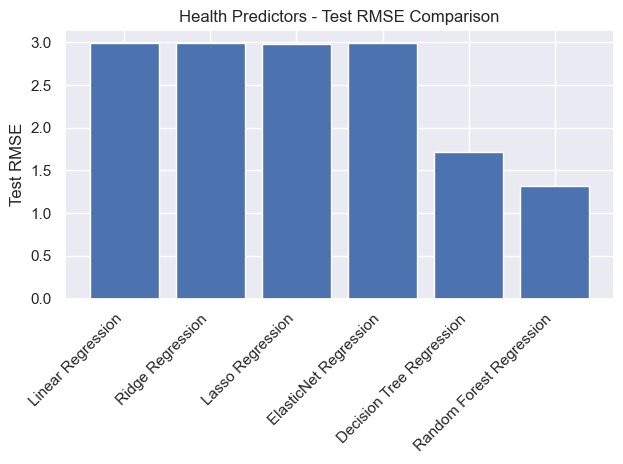


Summary Table for Test RMSE:
                   Model  Test RMSE
       Linear Regression   2.988608
        Ridge Regression   2.988433
        Lasso Regression   2.986613
   ElasticNet Regression   2.991349
Decision Tree Regression   1.718095
Random Forest Regression   1.315061




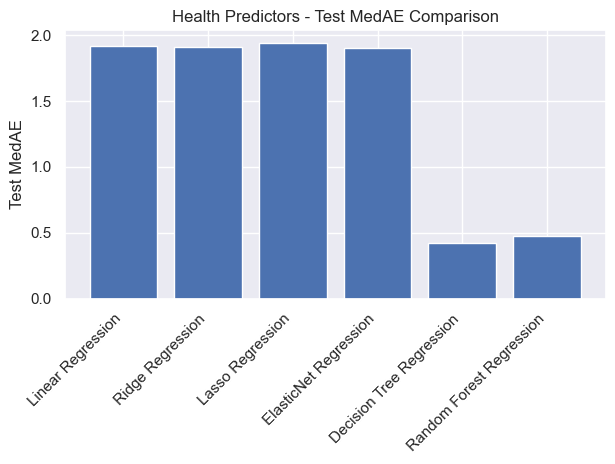


Summary Table for Test MedAE:
                   Model  Test MedAE
       Linear Regression    1.916947
        Ridge Regression    1.914650
        Lasso Regression    1.941055
   ElasticNet Regression    1.907265
Decision Tree Regression    0.419500
Random Forest Regression    0.475145




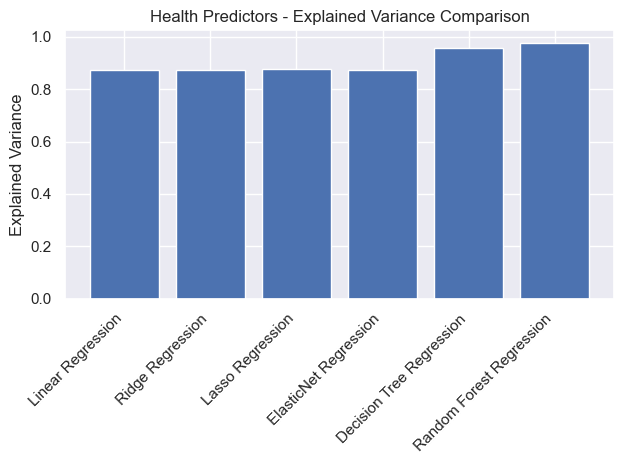


Summary Table for Explained Variance:
                   Model  Explained Variance
       Linear Regression            0.874966
        Ridge Regression            0.874982
        Lasso Regression            0.875192
   ElasticNet Regression            0.874785
Decision Tree Regression            0.958525
Random Forest Regression            0.975783




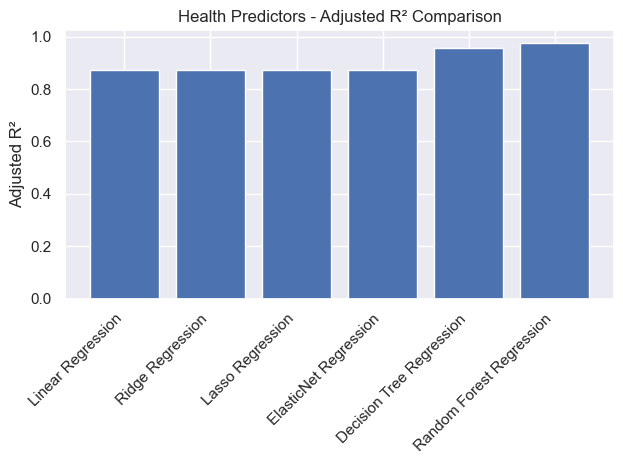


Summary Table for Adjusted R²:
                   Model  Adjusted R²
       Linear Regression     0.872046
        Ridge Regression     0.872061
        Lasso Regression     0.872217
   ElasticNet Regression     0.871811
Decision Tree Regression     0.957713
Random Forest Regression     0.975225




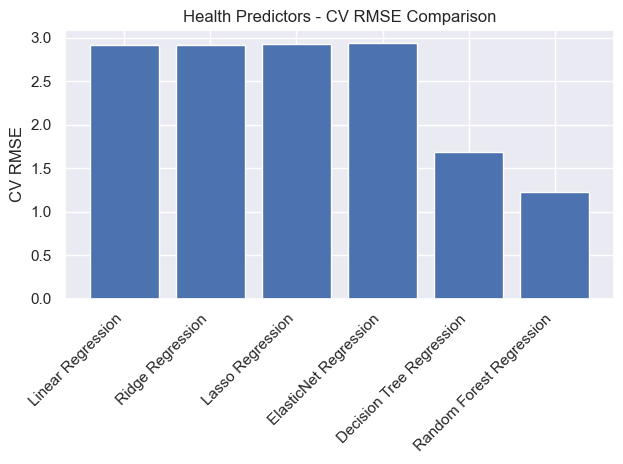


Summary Table for CV RMSE:
                   Model  CV RMSE
       Linear Regression 2.909372
        Ridge Regression 2.909334
        Lasso Regression 2.929907
   ElasticNet Regression 2.935713
Decision Tree Regression 1.687486
Random Forest Regression 1.228091




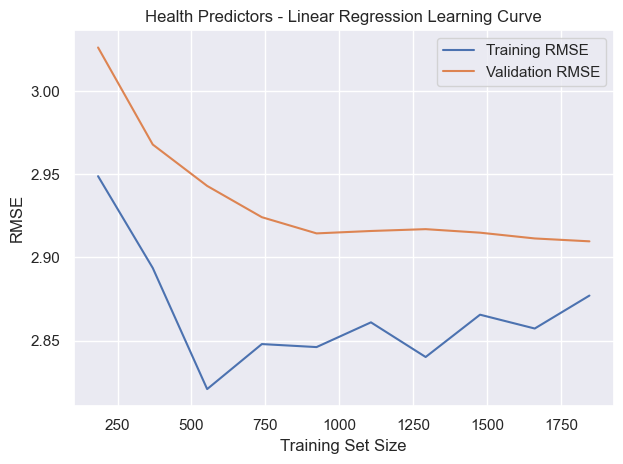

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             median_absolute_error, explained_variance_score)
from sklearn.model_selection import cross_val_score, learning_curve, train_test_split
from sklearn.preprocessing import StandardScaler

# ===============================================================
# Modified evaluation function that returns a dictionary of metrics
# ===============================================================
def evaluate_model(model, full_name, X_train, y_train, X_test, y_test, plot=True):
    # Fit the model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Compute various evaluation metrics
    mse    = mean_squared_error(y_test, y_pred)
    r2     = r2_score(y_test, y_pred)
    mae    = mean_absolute_error(y_test, y_pred)
    rmse   = np.sqrt(mse)
    medae  = median_absolute_error(y_test, y_pred)
    evs    = explained_variance_score(y_test, y_pred)
    n      = len(y_test)
    p      = X_test.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # 5-fold cross-validation RMSE on the training set
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse   = np.sqrt(-cv_scores).mean()
    
    # Optionally plot a residual plot
    if plot:
        residuals = y_test - y_pred
        plt.figure()
        plt.scatter(y_pred, residuals, alpha=0.7)
        plt.axhline(0, color='black', linestyle='--')
        plt.xlabel("Predicted Values")
        plt.ylabel("Residuals")
        plt.title(f"Residual Plot - {full_name}")
        plt.show()
    
    # Print a summary for the model
    print(f"========== {full_name} ==========")
    print("Test MSE:", mse)
    print("Test R²:", r2)
    print("Test MAE:", mae)
    print("Test RMSE:", rmse)
    print("Test Median AE:", medae)
    print("Explained Variance:", evs)
    print("Adjusted R²:", adjusted_r2)
    print("Cross-validated RMSE:", cv_rmse)
    
    return {
       "Model": "",  # Will be overwritten in the pipeline function
       "Test MSE": mse,
       "Test R²": r2,
       "Test MAE": mae,
       "Test RMSE": rmse,
       "Test MedAE": medae,
       "Explained Variance": evs,
       "Adjusted R²": adjusted_r2,
       "CV RMSE": cv_rmse
    }

# ===============================================================
# Pipeline function for splitting, scaling, evaluating, and summarizing
# ===============================================================
def run_model_pipeline(X, Y, category_name, test_size=0.2, random_state=135):
    """
    Processes predictor set X for a given category:
      - Converts to floats, splits into train and test,
      - Scales data and adds a constant,
      - Fits multiple regression models,
      - Collects key evaluation metrics,
      - Plots summary bar charts for all metrics and then prints a table (in text) for the metric,
      - Plots a learning curve for Linear Regression.
      
    Parameters:
        X (DataFrame): Predictor features for the category.
        Y (Series): Target variable.
        category_name (str): e.g., "Environmental".
        test_size (float): Proportion for testing.
        random_state (int): Seed for reproducibility.
        
    Returns:
        summary_df (DataFrame): A summary table of evaluation metrics for each model.
    """
    # Convert data type to float
    X = X.astype(float)
    Y = Y.astype(float)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=test_size, random_state=random_state
    )
    
    # Scale the predictors
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    
    # Convert back to DataFrame to retain column names
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled  = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    # Add a constant for the intercept
    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled  = sm.add_constant(X_test_scaled)
    
    print("================================")
    print(f"Category: {category_name}")
    print("================================")
    
    # Define regression models and their short names for summaries
    models = [
       (LinearRegression(),         "Linear Regression"),
       (Ridge(alpha=1.0),          "Ridge Regression"),
       (Lasso(alpha=0.1),          "Lasso Regression"),
       (ElasticNet(alpha=0.1, l1_ratio=0.5),  "ElasticNet Regression"),
       (DecisionTreeRegressor(random_state=42), "Decision Tree Regression"),
       (RandomForestRegressor(random_state=42), "Random Forest Regression")
    ]
    
    # Evaluate each model and collect metrics
    results_summary = []
    for model, short_name in models:
       full_name = f"{category_name} - {short_name}"
       metrics_dict = evaluate_model(
           model, full_name, X_train_scaled, y_train, X_test_scaled, y_test, plot=False
       )
       metrics_dict["Model"] = short_name  # Overwrite with short name only
       results_summary.append(metrics_dict)
       
    # Create a summary DataFrame
    summary_df = pd.DataFrame(results_summary)
    print("\nSummary of Evaluation Metrics:")
    print(summary_df)
    
    # List of metrics to plot and print a table below the figure
    metric_names = ["Test MSE", "Test R²", "Test MAE", "Test RMSE", "Test MedAE", "Explained Variance", "Adjusted R²", "CV RMSE"]
    
    # Loop over each metric to create a bar chart and then print a table
    for metric in metric_names:
        plt.bar(summary_df["Model"], summary_df[metric])
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{category_name} Predictors - {metric} Comparison")
        plt.ylabel(metric)
        plt.tight_layout()
        plt.show()
        
        # Print the summary table for this metric
        print(f"\nSummary Table for {metric}:")
        print(summary_df[["Model", metric]].to_string(index=False))
        print("\n")
    
    # Additionally, plot a learning curve for Linear Regression only
    train_sizes, train_scores, valid_scores = learning_curve(
       estimator=LinearRegression(),
       X=X_train_scaled,
       y=y_train,
       train_sizes=np.linspace(0.1, 1.0, 10),
       cv=5,
       scoring='neg_mean_squared_error'
    )
    train_rmse = np.sqrt(-train_scores.mean(axis=1))
    valid_rmse = np.sqrt(-valid_scores.mean(axis=1))
    plt.plot(train_sizes, train_rmse, label='Training RMSE')
    plt.plot(train_sizes, valid_rmse, label='Validation RMSE')
    plt.xlabel('Training Set Size')
    plt.ylabel('RMSE')
    plt.title(f'{category_name} Predictors - Linear Regression Learning Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return summary_df

# ===============================================================
# Example Usage:
# (Make sure you have defined your reduced predictor sets and Y)
#
summary_env    = run_model_pipeline(X_env_reduced, Y, "Environmental")
summary_socio  = run_model_pipeline(X_socio_reduced, Y, "Socioeconomic")
summary_health = run_model_pipeline(X_health_reduced, Y, "Health")
